In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/수리적빅데이터개론/OIBC

/content/drive/MyDrive/수리적빅데이터개론/OIBC


In [3]:
import pandas as pd
import numpy as np
import os

### 데이터를 모델 및 round로 나눔

In [4]:
gens = pd.read_csv('data/preprocessed/pp_gens.csv')

weather_forecast1 = pd.read_csv('data/preprocessed/pp_weather_forecast1.csv')
weather_forecast2 = pd.read_csv('data/preprocessed/pp_weather_forecast2.csv')

model0_1 = pd.read_csv('data/preprocessed/pp_model0_1.csv')
model1_1 = pd.read_csv('data/preprocessed/pp_model1_1.csv')
model2_1 = pd.read_csv('data/preprocessed/pp_model2_1.csv')
model3_1 = pd.read_csv('data/preprocessed/pp_model3_1.csv')
model4_1 = pd.read_csv('data/preprocessed/pp_model4_1.csv')

model0_2 = pd.read_csv('data/preprocessed/pp_model0_2.csv')
model1_2 = pd.read_csv('data/preprocessed/pp_model1_2.csv')
model2_2 = pd.read_csv('data/preprocessed/pp_model2_2.csv')
model3_2 = pd.read_csv('data/preprocessed/pp_model3_2.csv')
model4_2 = pd.read_csv('data/preprocessed/pp_model4_2.csv')

In [5]:
print(gens.shape)
print(model0_1.shape)
print(model0_2.shape)
print(model1_1.shape)
print(model1_2.shape)
print(model2_1.shape)
print(model2_2.shape)
print(model3_1.shape)
print(model3_2.shape)
print(model4_1.shape)
print(model4_2.shape)
print(weather_forecast1.shape)
print(weather_forecast2.shape)

(11568, 2)
(11568, 4)
(11568, 4)
(11568, 4)
(11568, 4)
(11568, 4)
(11568, 4)
(11568, 4)
(11568, 4)
(11568, 4)
(11568, 4)
(11568, 15)
(11568, 15)


### 데이터를 train과 valid로 나눔

In [23]:
y = gens['amount']
X = pd.DataFrame()
X['time'] = pd.to_datetime(model0_1['time']).dt.hour
X['model0_1'] = model0_1['amount']
X['model1_1'] = model1_1['amount']
X['model2_1'] = model2_1['amount']
X['model3_1'] = model3_1['amount']
X['model4_1'] = model4_1['amount']

X['model0_2'] = model0_2['amount']
X['model1_2'] = model1_2['amount']
X['model2_2'] = model2_2['amount']
X['model3_2'] = model3_2['amount']
X['model4_2'] = model4_2['amount']

In [24]:
X

,time,model0_1,model1_1,model2_1,model3_1,model4_1,model0_2,model1_2,model2_2,model3_2,model4_2
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11563,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11564,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11565,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11566,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print(X.shape, y.shape)

(11568, 11) (11568,)


In [42]:
from sklearn.model_selection import train_test_split

seed = 42
# 실제 발전량
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## 인센티브 계산

In [43]:
def calc_profit(actual_gens: list[int], forecast_gens: list[int]):
    CAPACITY = 99.0
    facility_utilization_rate = [actual / CAPACITY for actual in actual_gens]

    filter_facility_utilization_rate = [
        utilization >= 0.1 for utilization in facility_utilization_rate
    ]

    errors = [
        abs(forecast - actual) / CAPACITY * 100
        for forecast, actual in zip(forecast_gens, actual_gens)
    ]

    target_errors = [
        error
        for error, is_filtered in zip(errors, filter_facility_utilization_rate)
        if is_filtered
    ]
    target_actual_gens = [
        actual
        for actual, is_filtered in zip(
            actual_gens, filter_facility_utilization_rate
        )
        if is_filtered
    ]

    profits = [0] * len(target_actual_gens)

    for i, error in enumerate(target_errors):
        if error <= 6:
            profits[i] = target_actual_gens[i] * 4
        elif 6 < error <= 8:
            profits[i] = target_actual_gens[i] * 3

    return profits

## 가중치의 모든 순열


In [44]:
from itertools import product
# 가중치의 모든 순열
def all_permutations(input_list, select):

    numbers = input_list
    num_selected = select

    # 결과를 저장할 리스트
    results = []

    # 중복 순열 생성 및 합이 10인 경우 결과에 추가
    for combo in product(numbers, repeat=num_selected):
        if sum(combo) == 10:
            results.append(combo)

    return results

## 모든 순열 중 가장 incentive가 큰 값 선택

In [45]:
w_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
w_select = 5
def find_max_incentive_permutation(gens, m0, m1, m2, m3, m4):
    max_list = []
    max_incentive = 0
    for perm in all_permutations(w_list, w_select):
        temp = (m0*perm[0] + m1*perm[1] + m2*perm[2] + m3*perm[3] + m4*perm[4]) * 0.1
        incentive = sum(calc_profit(gens, temp))
        if (max_incentive < incentive):
            max_incentive = incentive
            max_list = perm
    return max_incentive, max_list

# 결과

In [47]:
result

,time,model0_1,model1_1,model2_1,model3_1,model4_1,model0_2,model1_2,model2_2,model3_2,model4_2
6723,4,0.0000,0.00000,0.000000,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0000
431,0,0.0000,0.00000,0.000000,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0000
6909,22,0.0000,0.00000,0.000000,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0000
1780,5,0.0000,0.00000,0.000000,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0000
5399,0,0.0000,0.00000,0.000000,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
11284,5,0.0000,0.00000,0.000000,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0000
5191,8,1.0469,2.89127,0.158823,0.0000,0.0000,1.67742,3.10505,0.093372,1.09615,0.0000
5390,15,62.6478,62.61670,73.920900,72.9072,44.0623,59.63340,61.08200,62.893500,54.22030,34.4457
860,21,0.0000,0.00000,0.000000,0.0000,0.0000,0.00000,0.00000,0.000000,0.00000,0.0000


In [46]:
# round 1
result1 = find_max_incentive_permutation(y_train, X_train['model0_1'], X_train['model1_1'], X_train['model2_1'], X_train['model3_1'], X_train['model4_1'])

# round 2
result2 = find_max_incentive_permutation(y_train, X_train['model0_2'], X_train['model1_2'], X_train['model2_2'], X_train['model3_2'], X_train['model4_2'])

print("round1: ", result1)
print("round2: ", result2)

round1:  (287255.9084000001, (0, 3, 0, 7, 0))
round2:  (286767.1032, (4, 5, 0, 1, 0))


## 검증

In [ ]:
# round1
w1 = result1[1]
custom1 = (X_test['model0_1']*w1[0] +
           X_test['model1_1']*w1[1] +
           X_test['model2_1']*w1[2] +
           X_test['model3_1']*w1[3] +
           X_test['model4_1']*w1[4]) * 0.1

model0_1_profit = sum(calc_profit(y_test, X_test['model0_1']))
model1_1_profit = sum(calc_profit(y_test, X_test['model1_1']))
model2_1_profit = sum(calc_profit(y_test, X_test['model2_1']))
model3_1_profit = sum(calc_profit(y_test, X_test['model3_1']))
model4_1_profit = sum(calc_profit(y_test, X_test['model4_1']))
custom1_profit = sum(calc_profit(y_test, custom1))
actual_profit = sum(calc_profit(y_test, y_test))

print("model0_1_profit: ", model0_1_profit)
print("model1_1_profit: ", model1_1_profit)
print("model2_1_profit: ", model2_1_profit)
print("model3_1_profit: ", model3_1_profit)
print("model4_1_profit: ", model4_1_profit)
print("custom1_profit: ", custom1_profit)
print("actual_profit: ", actual_profit)

model0_1_profit:  69038.22420000001
model1_1_profit:  68210.61449999998
model2_1_profit:  56514.0235
model3_1_profit:  67005.29149999999
model4_1_profit:  50660.610199999996
custom1_profit:  68496.2595
actual_profit:  151230.82240000003


In [5]:
test = [[1,2,3,4,5], [1,2,3,4,5]]
incentive = 0

for i in test:


In [6]:
incentive

30

In [ ]:
# round2
w2 = result2[1]
custom2 = (X_test['model0_2']*w2[0] +
           X_test['model1_2']*w2[1] +
           X_test['model2_2']*w2[2] +
           X_test['model3_2']*w2[3] +
           X_test['model4_2']*w2[4]) * 0.1

model0_2_profit = sum(calc_profit(y_test, X_test['model0_2']))
model1_2_profit = sum(calc_profit(y_test, X_test['model1_2']))
model2_2_profit = sum(calc_profit(y_test, X_test['model2_2']))
model3_2_profit = sum(calc_profit(y_test, X_test['model3_2']))
model4_2_profit = sum(calc_profit(y_test, X_test['model4_2']))
custom2_profit = sum(calc_profit(y_test, custom2))

print("model0_2_profit: ", model0_2_profit)
print("model1_2_profit: ", model1_2_profit)
print("model2_2_profit: ", model2_2_profit)
print("model3_2_profit: ", model3_2_profit)
print("model4_2_profit: ", model4_2_profit)
print("custom1_profit: ", custom1_profit)
print("actual_profit: ", actual_profit)

model0_2_profit:  69898.18129999998
model1_2_profit:  67923.70809999999
model2_2_profit:  63775.89299999999
model3_2_profit:  62612.85629999999
model4_2_profit:  51204.48259999999
custom1_profit:  68496.2595
actual_profit:  151230.82240000003


## 그래프

#### 마지막 하루치의 그래프만 그려봤음

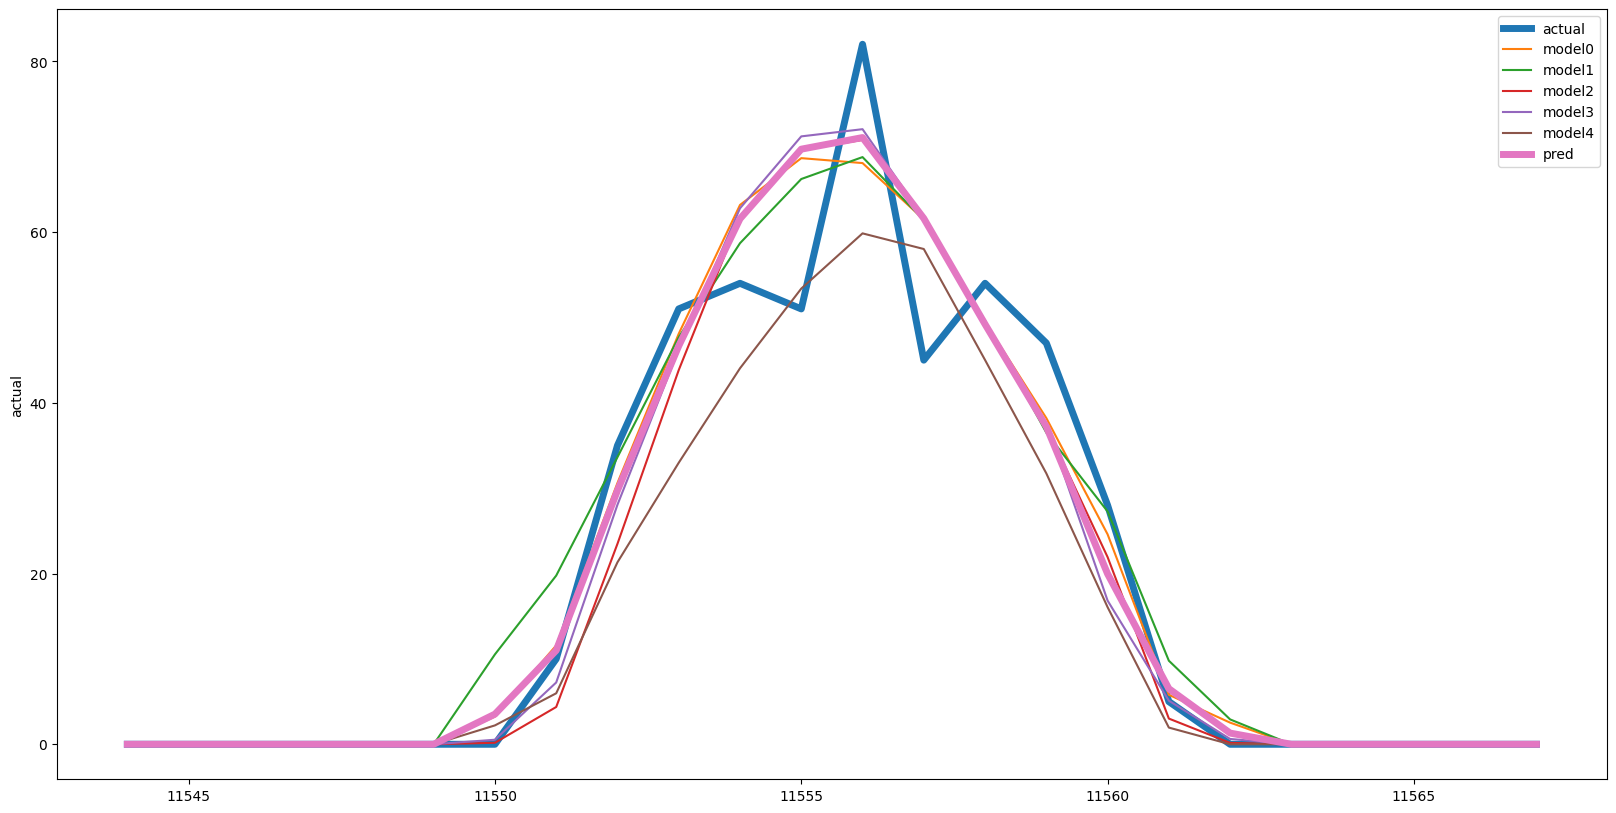

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
w = result1[1]
df = pd.DataFrame()
df['actual'] = gens['amount'].tail(24)
df['model0'] = model0_1['amount'].tail(24)
df['model1'] = model1_1['amount'].tail(24)
df['model2'] = model2_1['amount'].tail(24)
df['model3'] = model3_1['amount'].tail(24)
df['model4'] = model4_1['amount'].tail(24)
df['pred'] = (df['model0']*w[0] + df['model1']*w[1] + df['model2']*w[2] + df['model3']*w[3] + df['model4']*w[4]) * 0.1

# 그래프 크기 조절
plt.figure(figsize=(20, 10))  # (가로 크기, 세로 크기)를 지정합니다.

sns.lineplot(data=df['actual'], label='actual', linewidth=5)
sns.lineplot(data=df['model0'], label='model0')
sns.lineplot(data=df['model1'], label='model1')
sns.lineplot(data=df['model2'], label='model2')
sns.lineplot(data=df['model3'], label='model3')
sns.lineplot(data=df['model4'], label='model4')
sns.lineplot(data=df['pred'], label='pred', linewidth=5)
plt.show()

In [ ]:
print("actual: ", sum(calc_profit(df['actual'], df['actual'])))
print("model0: ", sum(calc_profit(df['actual'], df['model0'])))
print("model1: ", sum(calc_profit(df['actual'], df['model1'])))
print("model2: ", sum(calc_profit(df['actual'], df['model2'])))
print("model3: ", sum(calc_profit(df['actual'], df['model3'])))
print("model4: ", sum(calc_profit(df['actual'], df['model4'])))
print("pred: ", sum(calc_profit(df['actual'], df['pred'])))

actual:  1828.0
model0:  712.0
model1:  888.0
model2:  655.0
model3:  565.0
model4:  244.0
pred:  762.0


### round==2

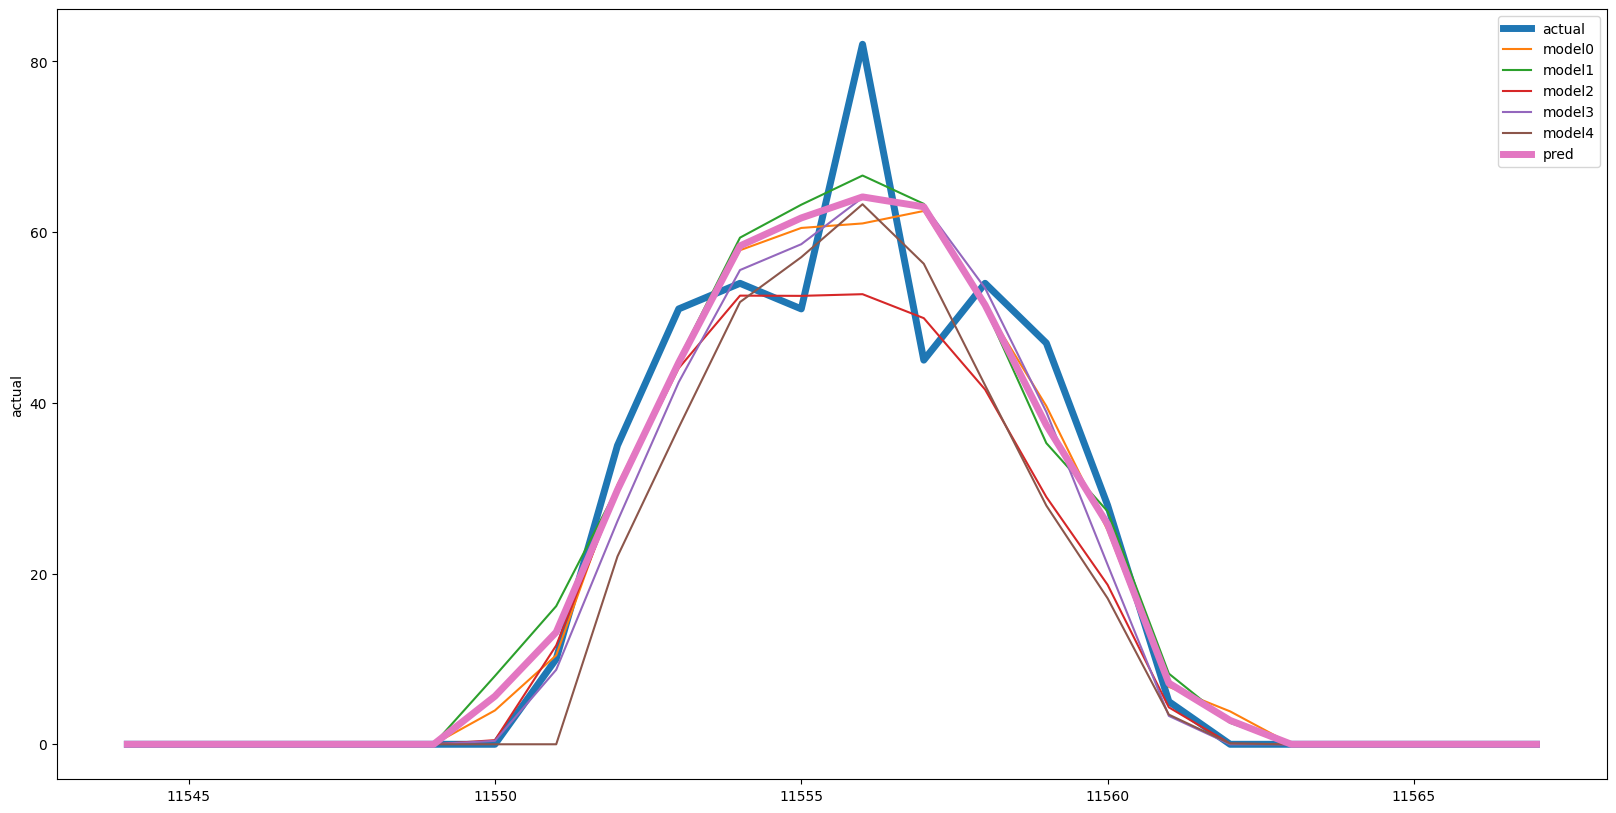

In [ ]:
w = result2[1]
df = pd.DataFrame()
df['actual'] = gens['amount'].tail(24)
df['model0'] = model0_2['amount'].tail(24)
df['model1'] = model1_2['amount'].tail(24)
df['model2'] = model2_2['amount'].tail(24)
df['model3'] = model3_2['amount'].tail(24)
df['model4'] = model4_2['amount'].tail(24)
df['pred'] = (df['model0']*w[0] + df['model1']*w[1] + df['model2']*w[2] + df['model3']*w[3] + df['model4']*w[4]) * 0.1

# 그래프 크기 조절
plt.figure(figsize=(20, 10))  # (가로 크기, 세로 크기)를 지정합니다.

sns.lineplot(data=df['actual'], label='actual', linewidth=5)
sns.lineplot(data=df['model0'], label='model0')
sns.lineplot(data=df['model1'], label='model1')
sns.lineplot(data=df['model2'], label='model2')
sns.lineplot(data=df['model3'], label='model3')
sns.lineplot(data=df['model4'], label='model4')
sns.lineplot(data=df['pred'], label='pred', linewidth=5)
plt.show()

In [ ]:
print("actual: ", sum(calc_profit(df['actual'], df['actual'])))
print("model0: ", sum(calc_profit(df['actual'], df['model0'])))
print("model1: ", sum(calc_profit(df['actual'], df['model1'])))
print("model2: ", sum(calc_profit(df['actual'], df['model2'])))
print("model3: ", sum(calc_profit(df['actual'], df['model3'])))
print("model4: ", sum(calc_profit(df['actual'], df['model4'])))
print("pred: ", sum(calc_profit(df['actual'], df['pred'])))

actual:  1828.0
model0:  1018.0
model1:  918.0
model2:  933.0
model3:  709.0
model4:  369.0
pred:  877.0
